<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/MMF_Tumor_Model_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KDD Tutorial
# Using MMF for knowledge based recommender systems

In this tutorial, we will show how we can use MMF to build a knowledge based recommender system. We will first show how we can setup a dataset inside MMF which in this case is [OKVQA](https://okvqa.allenai.org/) dataset. Then, we will dive deeper into how we can create a Multimodal Transformer which can answer knowledge based questions in OKVQA to a reasonable accuracy compared to the state-of-the-art.

### Prerequisites 
Please enable GPU in this notebook: Runtime > Change runtime type > Hardware Accelerator > Set to GPU

Throughout the tutorial, if you face any error related to a module not found, please restart your runtime.

# Install MMF and Dependencies

This involves cloning the MMF repo, installing it in develop mode and setting up the right versions of the dependencies already present in the colab.

In [5]:
## Enabled auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
!cd /content && git clone https://github.com/facebookresearch/mmf.git 

Cloning into 'mmf'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 14587 (delta 9), reused 13 (delta 2), pack-reused 14549
Receiving objects: 100% (14587/14587), 12.00 MiB | 23.19 MiB/s, done.
Resolving deltas: 100% (9252/9252), done.


In [ ]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!git checkout 95e89ee
!python --version && cd mmf && python setup.py develop
!pip install --upgrade pyyaml
!pip install --upgrade GitPython

## Add MMF to PATH so that it is discoverable

In [4]:
!pip install demjson

In [6]:
import sys
sys.path.append("/content/mmf")

from mmf.utils.env import setup_imports

setup_imports()

# Dataset

To create a dataset, there are three components:
1. An annotation database to load the annotation files provided by the dataset.
2. An image database which is provided by MMF and can be overridden if needed for specific use cases.
3. A builder class that is registered to MMF and returns back an instance of torch.utils.data.Dataset and will be used by MMF to load data which will be passed to the model.

Let's dive into details of each of this components.

### OKVQA Dataset

First, let's check how does the OKVQA dataset actually look like so that we can understand how do we have to create an annotation database based on this.

In [2]:
!wget -q https://okvqa.allenai.org/static/data/mscoco_val2014_annotations.json.zip && unzip -o mscoco_val2014_annotations.json.zip 

Archive:  mscoco_val2014_annotations.json.zip
  inflating: mscoco_val2014_annotations.json  


In [3]:
!wget -q https://okvqa.allenai.org/static/data/OpenEnded_mscoco_val2014_questions.json.zip && unzip -o OpenEnded_mscoco_val2014_questions.json.zip

Archive:  OpenEnded_mscoco_val2014_questions.json.zip
  inflating: OpenEnded_mscoco_val2014_questions.json  
   creating: __MACOSX/
  inflating: __MACOSX/._OpenEnded_mscoco_val2014_questions.json  


In [35]:
import json
with open("annotations.json") as f:
  annotations = json.load(f)
with open("questions.json") as f:
  questions = json.load(f)

print("Annotation keys: ", annotations.keys())
print("Annotation: ", annotations["annotations"][0])
print("Question keys: ", questions.keys())
print("Question: ", questions["questions"][0])

Annotation keys:  dict_keys(['license', 'data_subtype', 'question_types', 'annotations', 'info', 'data_type'])
Annotation:  {'image_id': 1, 'answer_type': 'other', 'question_type': 'one', 'question_id': 11, 'answers': [{'answer_id': 1, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 2, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 3, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 4, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 5, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 6, 'raw_answer': 'racing', 'answer_confidence': 'yes', 'answer': 'race'}, {'answer_id': 7, 'raw_answer': 'motocross', 'answer_confidence': 'yes', 'answer': 'motocross'}, {'answer_id': 8, 'raw_answer': 'motocross', 'answer_confidence': 'yes', 'answer': 'motocross'}, {'answer_id': 9, 'raw_answer': 'riding', 'answer_confidence':

## Creating the annotation database

The annotation database loads annotations from the data provided by the dataset and sets it to data variable. `self.data` should be list where an index can be passed to get a corresponding unique data same as how it works with torch.utils.dataset.Dataset.

We will override `load_annotation_db` method here to load our custom data. MMF's default `AnnotationDatabase` does handle a lot of common cases on its own, but if your data doesn't fit any of them, like in this case, create your own.

**Note:** If next command fails, please restart the runtime from "Runtime > Restart runtime" and run the command again.

In [36]:
import json

from mmf.datasets.databases.annotation_database import AnnotationDatabase

## Inherit default MMF's AnnotationDatabase and update necessary
## function `load_annotation_db`
class OKVQAAnnotationDatabase(AnnotationDatabase):
  def load_annotation_db(self, path: str):
    # Expect two paths, one to questions and one to annotations
    path = 'annotations.json,questions.json'

    path = path.split(",")
    # print(path)
    assert len(path) == 2, (
        "OKVQA requires 2 paths; one to questions and one to annotations"
    )

    with open(path[0]) as f:
      path_0 = json.load(f)
    with open(path[1]) as f:
      path_1 = json.load(f)

    if "annotations" in path_0:
      annotations = path_0
      questions = path_1
    else:
      annotations = path_1
      questions = path_0
    
    # Convert to linear format
    data = []
    question_dict = {}
    for question in questions["questions"]:
      question_dict[question["question_id"]] = question["question"]

    for annotation in annotations["annotations"]:
      annotation["question"] = question_dict[annotation["question_id"]]
      answers = []
      for answer in annotation["answers"]:
        answers.append(answer["answer"])
      annotation["answers"] = answers
      data.append(annotation)
    
    self.data = data


### Building the dataset

Now, we will build the OKVQA dataset object that follows the syntax same as
torch.utils.data.Dataset. We will implement the `__getitem__` function and `__len__` is already implemented in the MMFDataset which equals to length of the annotation database.

To use our custom annotation database, we will override the `build_annotation_db` function.

In [43]:
import numpy as np

from typing import Dict

from mmf.common.sample import Sample
from mmf.datasets.mmf_dataset import MMFDataset
from mmf.utils.visualize import visualize_images


class OKVQADataset(MMFDataset):
  def __init__(self, config: Dict, dataset_type: str, index, *args, **kwargs):
    # The super call will build annotation database, image database and 
    # feature database based on config passed.
    super().__init__("okvqa_colab", config, dataset_type, index, *args, **kwargs)
  
  def build_annotation_db(self):
    """
    We are overriding this function to return our custom AnnotationDatabase
    which we built specifically for OKVQA. Similarly, we can override
    build_image_db and build_feature_db for to implement custom versions of
    those for a particular dataset.
    """
    annotation_path = self._get_path_based_on_index(
        self.config, "annotations", self._index
    )
    return OKVQAAnnotationDatabase(self.config, annotation_path)
  
  def get_image_path(self, image_id: str):
    """
    Utility function to convert COCO image id to actual image path
    """
    if self.dataset_type == "train":
      image_path = "images/1.png"
    else:
      image_path = "images/1.png" #f"COCO_val2014_{str(image_id).zfill(12)}.jpg"
    return image_path  

  def init_processors(self):
    super().init_processors()
    # Transforms need to be set to image_processor manually
    self.image_db.transform = self.image_processor  

  def __getitem__(self, idx: int):
    # Take the data sample from the annotation db (basically the annotation)
    sample_info = self.annotation_db[idx]
    current_sample = Sample()
    # Pass it to question processor to process the question
    # This in a lot of cases will be defined in the experiment config and
    # is interchangable with others. Defaults to glove processor and in
    # this colab we will use bert processors defined in the experiment config.
    processed_question = self.text_processor({"text": sample_info["question"]})
    current_sample.update(processed_question)

    current_sample.id = torch.tensor(
        int(sample_info["question_id"]), dtype=torch.int
    )

    # Get the first image from the set of images returned from the image_db
    image_path = self.get_image_path(sample_info["image_id"])
    current_sample.image = self.image_db.from_path(image_path)["images"][0]

    if "answers" in sample_info:
      answers = self.answer_processor({"answers": sample_info["answers"]})
      current_sample.targets = answers["answers_scores"]
    return current_sample
  
  def visualize(
      self, 
      num_samples: int=1, 
      use_transforms: bool=False, 
      *args, 
      **kwargs
  ):
    """
    Visualize function displays `num_samples` number of samples from the dataset.
    In this case, it will print out the question and a grid of the random images
    from the dataset.
    """
    image_paths = []
    random_samples = np.random.randint(0, len(self), size=num_samples)
    questions = []
    for idx in random_samples:
        image_paths.append(
            self.get_image_path(self.annotation_db[idx]["image_id"])
        )
        questions.append(self.annotation_db[idx]["question"])
    images = self.image_db.from_path(image_paths, use_transforms=use_transforms)
    print("\n".join(questions))
    visualize_images(images["images"], *args, **kwargs)

In [38]:
from mmf.common.registry import registry
from mmf.datasets.mmf_dataset_builder import MMFDatasetBuilder

# Register as okvqa_colab because okvqa already exists in MMF master branch
@registry.register_builder("okvqa_colab")
class OKVQABuilder(MMFDatasetBuilder):
  ZOO_CONFIG_PATH = "/content/configs/zoo.yaml"
  def __init__(
      self, 
      dataset_name="okvqa_colab", 
      dataset_class=OKVQADataset, 
      *args, 
      **kwargs,
  ):
    super().__init__(dataset_name, dataset_class, *args, **kwargs)
  
  @classmethod
  def config_path(cls):
    return "/content/configs/okvqa_colab.yaml"

In [11]:
!mkdir -p /content/configs/ \
  && wget -q https://raw.githubusercontent.com/facebookresearch/mmf/master/mmf/configs/datasets/okvqa/defaults.yaml \
  -O "/content/configs/okvqa_colab.yaml" \
  && sed -i "s/okvqa:/okvqa_colab:/g" /content/configs/okvqa_colab.yaml \
  && sed -i "s/okvqa\//okvqa_colab\//g" /content/configs/okvqa_colab.yaml \
  && sed -i "s/okvqa\.defaults/okvqa_colab\.defaults/g" /content/configs/okvqa_colab.yaml \
  && cat /content/configs/okvqa_colab.yaml

dataset_config:
  okvqa_colab:
    data_dir: ${env.data_dir}/datasets
    use_images: true
    use_features: false
    zoo_requirements:
    - okvqa_colab.defaults
    images:
      train:
      - okvqa_colab/defaults/images/
      val:
      - okvqa_colab/defaults/images/
      test:
      - okvqa_colab/defaults/images/
    annotations:
      train:
      - okvqa_colab/defaults/annotations/mscoco_train2014_annotations.json,okvqa_colab/defaults/annotations/OpenEnded_mscoco_train2014_questions.json
      val:
      - okvqa_colab/defaults/annotations/mscoco_val2014_annotations.json,okvqa_colab/defaults/annotations/OpenEnded_mscoco_val2014_questions.json
      test:
      - okvqa_colab/defaults/annotations/mscoco_val2014_annotations.json,okvqa_colab/defaults/annotations/OpenEnded_mscoco_val2014_questions.json
    processors:
      text_processor:
        type: vocab
        params:
          max_length: 14
          vocab:
            type: intersected
            embedding_name: glove.6B

In [39]:
import yaml


zoo_config = {
    "okvqa_colab": {
        "defaults": {
            "version": 1.020200716,
            "resources": {
                "images": [
                    {
                        "url": "mmf://datasets/okvqa/defaults/images/images.tar.gz",
                        "file_name": "images.tar.gz",
                        "hashcode": "674380cee4285a495c398fe9265224052b04454e4599d56b844f0453140ea82f",
                    }
                ],
                "extras": [
                    {
                        "url": "mmf://datasets/okvqa/defaults/extras.tar.gz",
                        "file_name": "extras.tar.gz",
                        "hashcode": "9a1cc2f2abedcee494917fae853069d8e465dad050307221b7969c9d65ed1b45",
                    }
                ],
                "annotations": [
                    {
                        "url": "https://okvqa.allenai.org/static/data/mscoco_train2014_annotations.json.zip",
                        "file_name": "mscoco_train2014_annotations.json.zip",
                    },
                    {
                        "url": "https://okvqa.allenai.org/static/data/mscoco_val2014_annotations.json.zip",
                        "file_name": "mscoco_val2014_annotations.json.zip",
                    },
                    {
                        "url": "https://okvqa.allenai.org/static/data/OpenEnded_mscoco_train2014_questions.json.zip",
                        "file_name": "OpenEnded_mscoco_train2014_questions.json.zip",
                    },
                    {
                        "url": "https://okvqa.allenai.org/static/data/OpenEnded_mscoco_val2014_questions.json.zip",
                        "file_name": "OpenEnded_mscoco_val2014_questions.json.zip",
                    },
                ],
            },
        }
    }
}

with open("/content/configs/zoo.yaml", "w") as f:
  yaml.dump(zoo_config, f)

In [48]:
from mmf.utils.build import build_dataset
from mmf.utils.configuration import Configuration

# Init configuration to register resolvers
Configuration()
dataset = build_dataset("okvqa_colab", dataset_type="val")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)
# dataset.visualize(num_samples=8, size=(512, 512), nrow=4)

# **Model**

Now we will build a model for the OKVQA task. This requires the model to take multiple inputs(text questions as well as images). MMF has built-in support for multimodal tasks and offers tons of features to easily build multimodal models. In this specific case we will build a trasnformer model for the OKVQA task. 

 

## Modality Encoders and Multimodal Embedding

For the different modalities we need to first have encoders for each and then process these encoded inputs and build embeddings for each. In this section we will define our Image encoder class for the image input. MMF datasets already preprocess the text input and generate tokens by passing the text through a Bert Tokenizer encoder(we will specify which type of  in our configs later). First we will build an embedding class, which will generate a combined embedding for our multimodal inputs. We will generate three types of embeddings for each modality first which takes three types of tokens:

1. Input ID tokens (which are either text tokens or image features)
2. Position ID tokens (position of the text tokens or image features)
3. Segment ID tokens (token type , either text or image to differentiate)



In [14]:
from typing import Any, Dict

import torch
from torch import Tensor, nn

from mmf.modules.encoders import MultiModalEncoderBase


class ImageEncoder(MultiModalEncoderBase):
    """Extends the MultiModalEncoderBase class which builds the encoder based on
     the config parameters. We can set the type of image encoder(resnet50, 
     resnet152, resnext50 etc) and other parameters like num of features, 
     type of pooling etc.
    """
    def __init__(self, config):
        super().__init__(config)

    def build(self):
        self.encoder = self._build_modal_encoder(self.config.image_encoder)

    def forward(self, x):
        return self.encoder(x)


class MMFTransformerEmbeddings(nn.Module):
    """Embedding class takes two types of modalities(image and text), each can 
    have their input id, position id and segment id. We generate embeddings of 
    dimension config.hidden_size for each and then first add the three embeddings
    for each modality to have a modality specific embedding. We then concat the 
    modality specific embeddings to have a joint embedding.
    """
    def __init__(self, config, transformer, img_dim, img_pos_dim):
        super().__init__()

        # Text Embeddings
        self.word_embeddings = transformer.embeddings.word_embeddings
        self.position_embeddings = transformer.embeddings.position_embeddings
        self.layer_norm = transformer.embeddings.LayerNorm
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Image Embeddings
        self.img_embeddings = nn.Sequential(
            nn.Linear(img_dim, config.hidden_size),
            torch.nn.LayerNorm(config.hidden_size, eps=1e-12),
        )
        self.img_pos_embeddings = nn.Sequential(
            nn.Linear(img_pos_dim, config.hidden_size),
        )
        self.img_layer_norm = torch.nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.img_dropout = nn.Dropout(config.hidden_dropout_prob)

        # Token Type Embeddings
        self.token_type_embeddings = transformer.embeddings.token_type_embeddings

    def forward(
        self,
        input_ids: Dict[str, Tensor],
        position_ids: Dict[str, Tensor],
        segment_ids: Dict[str, Tensor],
    ):
        ## Calculate text embeddings for word, position, segment type
        words_embeddings = self.word_embeddings(input_ids["text"])
        # Add position ids for text tokens
        if "text" not in position_ids:
            position_ids["text"] = input_ids["text"].new_tensor(
                torch.arange(0, input_ids["text"].size(1), dtype=torch.long)
                .unsqueeze(0)
                .expand(input_ids["text"].size(0), input_ids["text"].size(1))
            )
        position_embeddings = self.position_embeddings(position_ids["text"])
        if "text" not in segment_ids:
            segment_ids["text"] = torch.zeros_like(input_ids["text"])
        txt_type_embeddings = self.token_type_embeddings(segment_ids["text"])

        txt_embeddings = self.layer_norm(
            words_embeddings + position_embeddings + txt_type_embeddings
        )
        txt_embeddings = self.dropout(txt_embeddings)

        ## Calculate image embeddings for feature, position, segment type
        transformed_input = self.img_embeddings(input_ids["image"])
        img_embeddings = transformed_input
        if "image" in position_ids:
            transformed_pos = self.position_embeddings(position_ids["image"])
            img_embeddings += transformed_pos

        if "image" not in segment_ids:
            segment_ids["image"] = torch.zeros_like(
                input_ids["image"][:, :, 0], dtype=torch.long
            )
        img_type_embeddings = self.token_type_embeddings(segment_ids["image"])
        img_embeddings += img_type_embeddings

        img_embeddings = self.img_dropout(self.img_layer_norm(img_embeddings))

        return torch.cat([txt_embeddings, img_embeddings], dim=1)

## Transformer based multimodal model

Here we will start to implement our model. MMF comes out of the box with the required boilerplate structure to build transformer models for solving multimodal tasks. MMF has a `BaseTransformer` class which comes with some building blocks to easily import transformer models from [Huggingface transformers](https://github.com/huggingface/transformers) library and modify them for multi-modal use cases. Extending this base class, we will just need to implement few methods which are specific for our model. These are:

```
  self.build_transformer()
  self.build_encoders()
  self.build_embeddings()
  self.build_heads()
  self.build_losses()
```

The methods are self explanatory and we will definee each in detail as we build them. `build_transformer()` method is optional to override as base class provides ability load any transformer model from [Huggingface transformers](https://github.com/huggingface/transformers) just by specifying the name of the model. For example in your model config you can specify 
```
"transformer_base": "bert-base-uncased"
```
and the BERT Base model with pretrained weights will be available inside the class as `self.transformer`. We will need the encoder and embeddings from this transformer model, which can be accessed by `self.transformer.encoder` and `self.transformer.embeddings`. 

Oncce we initialize the different components of our model, we will implement the forward pass. The flow that we will use to implement it is as follows:

```

                    preprocess_sample                          ||
                            |                                  ||
                   generate embeddings                         ||
                            |                                  ||
                 generate attention masks                      ||     MODEL
                            |                                  ||
                 transformer encoder pass                      ||     FLOW
                            |                                  ||
                   different head pass                         ||   DIRECTION
                            |                                  ||
                   postprocess_output                          ||
                            |                                  ||
                 Dict[str, Tensor] output                      \/

        Returns:
            Dict[str, Tensor]: Dict containing scores or losses
```

The input to a models' forward pass in MMF is a `SampleList`. We will preprocess the `SampleList` to generate the required inputs to pass to the embedding layer.  

In [15]:
from transformers.modeling_bert import BertPooler, BertPredictionHeadTransform

from mmf.common.registry import registry
from mmf.common.typings import DictConfig
from mmf.models.transformers.base import BaseTransformer, BaseTransformerInput, BaseTransformerConfigType

@registry.register_model("mmf_transformer")
class MMFTransformer(BaseTransformer):
    def __init__(self, config: BaseTransformerConfigType):
        super().__init__(config)

    @classmethod
    def config_path(cls):
        return "/content/mmf_transformer_config.yaml"

    def build_encoders(self):
        self.image_encoder = ImageEncoder(self.config)

    def build_embeddings(self):
        # Here we initialize the embedding class we will use for multiple 
        # modalities (here just text and image). For the text embeeddings we 
        # will use the pretrained weights from the trasnformer model rather than
        # training from scratch.
        self.embeddings = MMFTransformerEmbeddings(
            self.transformer_config,
            self.transformer,
            self.config.visual_embedding_dim,
            self.config.visual_position_dim,
        )

    def build_heads(self):
        # Here we initialize the classifier head. It takes the output of the 
        # transformer encoder and passes it through a pooler (we use the pooler 
        # from BERT model), then dropout, BertPredictionHeadTransform (which is 
        # a liner layer, followed by activation and layer norm) and lastly a 
        # linear layer projecting the hidden output to classification 
        # labels.
        self.classifier = nn.Sequential(
            BertPooler(self.transformer_config),
            nn.Dropout(self.transformer_config.hidden_dropout_prob),
            BertPredictionHeadTransform(self.transformer_config),
            nn.Linear(self.transformer_config.hidden_size, self.config.num_labels),
        )

    def preprocess_sample(self, sample_list: Dict[str, Any]) -> BaseTransformerInput:
        # Here we preprocess the sample list elements and form a BaseTransformerInput
        # type object. This object standardizes how we represent multiple modalities.
        # Check the definition of this dataclass in BaseTransformer.

        # Input IDs (or text tokens/image features)
        input_ids: Dict[str, Tensor] = {}
        input_ids["text"] = sample_list.input_ids
        if "image_feature_0" in sample_list:
            input_ids["image"] = sample_list.image_feature_0
        elif "image" in sample_list:
            input_ids["image"] = self.image_encoder(sample_list.image)

        # Position IDs
        position_ids: Dict[str, Tensor] = {}
        position_ids["image"] = input_ids["image"].new_tensor(
            torch.arange(0, input_ids["image"].size(1), dtype=torch.long)
            .unsqueeze(0)
            .expand(input_ids["image"].size(0), input_ids["image"].size(1)),
            dtype=torch.long,
        )

        # Segment IDs
        segment_ids: Dict[str, Tensor] = {}
        segment_ids["text"] = sample_list.segment_ids

        # Masks
        masks: Dict[str, Tensor] = {}
        masks["text"] = sample_list.input_mask
        if "image_mask" in sample_list:
            masks["image"] = sample_list.image_mask
        else:
            masks["image"] = torch.ones_like(
                input_ids["image"][:, :, 0], dtype=torch.long
            )

        return BaseTransformerInput(input_ids, position_ids, segment_ids, masks)

    def forward(self, sample_list: Dict[str, Any]) -> Dict[str, Tensor]:
        # Sample preprocess
        output = self.preprocess_sample(sample_list)

        # Transformer Input Embeddings
        embedding_output = self.embeddings(
            input_ids=output.input_ids,
            position_ids=output.position_ids,
            segment_ids=output.segment_ids,
        )

        # Transformer Attention mask
        # concat the attention masks for text and image
        attention_mask = torch.cat(
            (output.masks["text"], output.masks["image"]), dim=-1
        )
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # Transformer Encoder
        encoded_layers = self.transformer.encoder(
            embedding_output,  # combined embedding
            extended_attention_mask,  # combined attention mask
            [None] * len(self.transformer.encoder.layer),  # head masks
        )

        # Transformer Heads
        head_output = self.classifier(encoded_layers[0])

        # Postprocess outputs
        return self.postprocess_output(head_output)

    def postprocess_output(self, output: Tensor) -> Dict[str, Tensor]:
        # Here we postprocess the output from the classifier head and reshape it.
        # This will be used to calculate losses and metrics in mmf.
        output_dict = {}
        output_dict["scores"] = output.contiguous().view(-1, self.config.num_labels)
        return output_dict


## Model Configuration

Here we build the configuration for the model we just implemented. Some of the config parameters are required to initialize weights for different layers of the model. We also define the image encoder parameters here.

In [16]:
# Create a model configuration file
mmf_transformer_config = {
   "model_config":{
      "mmf_transformer":{
         "transformer_base": "bert-base-uncased",
         "training_head_type": "classification",
         "visual_embedding_dim": 2048,
         "visual_position_dim": 1,
         "type_vocab_size": 2,
         "modalities":[
            "text",
            "image"
         ],
         "initializer_range": 0.02,
         "initializer_mean": 0.0,
         "layer_norm_weight_fill": 1.0,
         "random_initialize": False,
         "freeze_base": False,
         "finetune_lr_multiplier": 1,
         "image_encoder": {
            "type": "resnet152",
            "params": {
               "pretrained": True,
               "pool_type": "avg",
               "num_output_features": 1
            }
         }
      }
   }
}

# Save the dict into a yaml config file to load with mmf
import yaml
with open("/content/mmf_transformer_config.yaml", "w+") as f:
  yaml.dump(mmf_transformer_config, f, allow_unicode=True, default_flow_style=False)

# Display contents of the saved yaml file
!cat /content/mmf_transformer_config.yaml



model_config:
  mmf_transformer:
    finetune_lr_multiplier: 1
    freeze_base: false
    image_encoder:
      params:
        num_output_features: 1
        pool_type: avg
        pretrained: true
      type: resnet152
    initializer_mean: 0.0
    initializer_range: 0.02
    layer_norm_weight_fill: 1.0
    modalities:
    - text
    - image
    random_initialize: false
    training_head_type: classification
    transformer_base: bert-base-uncased
    type_vocab_size: 2
    visual_embedding_dim: 2048
    visual_position_dim: 1


## Experiment Configuration

Next we will create the configuration for our experiment. Here we will add configurations for components like scheduler, optimizer, evaluation metrics, training metrics and also override some default dataset configurations specifically for our model.



In [17]:
# Create an experiment configuration file
experiment_config = {
   # Scheduler to be used, type `warmup_linear`
   "scheduler":{
      "type":"warmup_linear",
      "params":{
         "num_warmup_steps":2000,
         "num_training_steps":22000,
      }
   },
   # Override the text processor for the dataset. Since we are using a 
   # transformer based model with a BERT base, we will override the tokenizer 
   # with a BERT tokenizer.
   "dataset_config":{
      "okvqa_colab":{
         "processors":{
            "text_processor":{
               "type":"bert_tokenizer",
               "params":{
                  "tokenizer_config":{
                     "type":"bert-base-uncased",
                     "params":{
                        "do_lower_case":True
                     }
                  },
                  "mask_probability":0,
                  "max_seq_length":128
               }
            }
         }
      }
   },
   # Some model specific configurations. We define which type of training head 
   # we want to use (this is useful when multiple different training heads are 
   # defined for the model). We also specify the number of classification labels
   # and type of loss to be used.
   "model_config":{
      "mmf_transformer":{
         "training_head_type":"classification",
         "num_labels":2,
         "losses":[
            {
               "type":"logit_bce"
            }
         ]
      }
   },
   # Optimizer used is AdamW with LR 5e-05
   "optimizer":{
      "type":"adam_w",
      "params":{
         "lr":5e-05,
         "eps":1e-08
      }
   },
   # OKVQA uses same metric as VQA evaluation
   "evaluation":{
      "metrics":[
         "vqa_accuracy"
      ]
   },
   # We change some training parameters here. 
   "training":{
      "batch_size":32,
      "lr_scheduler": True,
      "max_updates":22000,
      "early_stop":{
         "criteria":"okvqa_colab/vqa_accuracy",
         "minimize": False
      }
   },
}

# Save the dict into a yaml config file to load with mmf
import yaml
with open("/content/experiment_config.yaml", "w+") as f:
  yaml.dump(experiment_config, f, allow_unicode=True, default_flow_style=False)

# Display and verify contents of the saved yaml file
!cat /content/experiment_config.yaml

dataset_config:
  okvqa_colab:
    processors:
      text_processor:
        params:
          mask_probability: 0
          max_seq_length: 128
          tokenizer_config:
            params:
              do_lower_case: true
            type: bert-base-uncased
        type: bert_tokenizer
evaluation:
  metrics:
  - vqa_accuracy
model_config:
  mmf_transformer:
    losses:
    - type: logit_bce
    num_labels: 2253
    training_head_type: classification
optimizer:
  params:
    eps: 1.0e-08
    lr: 5.0e-05
  type: adam_w
scheduler:
  params:
    num_training_steps: 22000
    num_warmup_steps: 2000
  type: warmup_linear
training:
  batch_size: 32
  early_stop:
    criteria: okvqa_colab/vqa_accuracy
    minimize: false
  lr_scheduler: true
  max_updates: 22000


# Running the experiment

We now have all the components ready to start our experiment. MMF provides cli commands for running training, prediction etc and those can also be executed as function calls. Here we show how to  and send them as params to the `run` method.

We will also unregister processor register to registry during visualization of dataset to avoid any caches of other datasets.

In [49]:
from mmf.common.registry import registry

_ = registry.unregister("okvqa_colab_text_processor")

In [53]:
from mmf_cli.run import run

opts = [
        "config=/content/experiment_config.yaml",
        "model=mmf_transformer",
        "dataset=okvqa_colab",
        "training.log_interval=10",
        "training.batch_size=1",
        # Head is in dangling state, ignore git details in checkpoints
        "checkpoint.save_git_details=False",
]


run(opts)

2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option config to /content/experiment_config.yaml
2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option model to mmf_transformer
2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option datasets to okvqa_colab
2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option training.log_interval to 10
2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option training.batch_size to 1
2020-09-03T22:06:38 | mmf.utils.configuration: Overriding option checkpoint.save_git_details to False
2020-09-03T22:06:38 | mmf_cli.run: Namespace(config_override=None, opts=['config=/content/experiment_config.yaml', 'model=mmf_transformer', 'dataset=okvqa_colab', 'training.log_interval=10', 'training.batch_size=1', 'checkpoint.save_git_details=False'])
2020-09-03T22:06:38 | mmf_cli.run: Torch version: 1.5.0+cu101
2020-09-03T22:06:38 | mmf.utils.general: CUDA Device 0 is: Tesla T4
2020-09-03T22:06:38 | mmf_cli.run: Using seed

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


2020-09-03T22:14:52 | mmf.trainers.callbacks.checkpoint: Checkpoint time. Saving a checkpoint.


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


KeyboardInterrupt: ignored

# Inference on validation set

In [2]:
## Download the pretrained model
!wget https://dl.fbaipublicfiles.com/mmf/data/okvqa_mmft.ckpt

--2020-09-03 21:14:16--  https://dl.fbaipublicfiles.com/mmf/data/okvqa_mmft.ckpt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1583872909 (1.5G) [application/octet-stream]
Saving to: ‘okvqa_mmft.ckpt’

okvqa_mmft.ckpt     100%[===================>]   1.47G  72.6MB/s    in 23s     

2020-09-03 21:14:39 (67.1 MB/s) - ‘okvqa_mmft.ckpt’ saved [1583872909/1583872909]



In [ ]:
# Model inference on validation set
from mmf_cli.run import run


opts = [
        "config=/content/experiment_config.yaml",
        "model=mmf_transformer",
        "dataset=okvqa_colab",
        "run_type=val",
        "training.batch_size=8",
        "checkpoint.resume_file=okvqa_mmft.ckpt",
        # Head is in dangling state, ignore git details in checkpoints
        "checkpoint.save_git_details=False",
]


run(opts)

# Evaluation on test samples


In [21]:
# Build config, processors and model

## Build configuration
from omegaconf import OmegaConf

dataset_conf = OmegaConf.load('/content/configs/okvqa_colab.yaml')
model_conf = OmegaConf.load('/content/mmf_transformer_config.yaml')
experiment_conf = OmegaConf.load('/content/experiment_config.yaml')
extra_args = ["env.data_dir=/root/.cache/torch/mmf/data/"]
extra_args = OmegaConf.from_dotlist(extra_args)

conf = OmegaConf.merge(dataset_conf, model_conf, experiment_conf, extra_args)

conf.dataset_config.okvqa_colab.processors.answer_processor.params.vocab_file="/root/.cache/torch/mmf/data/datasets/" + conf.dataset_config.okvqa_colab.processors.answer_processor.params.vocab_file

## Build processors

from mmf.utils.build import build_processors

mmf_processors = build_processors(conf.dataset_config.okvqa_colab.processors)


## Build model
model = MMFTransformer(conf.model_config.mmf_transformer)
model.build()
model.init_losses()

state_dict = torch.load('okvqa_mmft.ckpt')
model.load_state_dict(state_dict["model"])
model.to("cuda")
model.eval()
print("Model Loaded Successfully!!")


2020-09-03T21:18:11 | transformers.tokenization_utils: loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2020-09-03T21:18:12 | transformers.configuration_utils: loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2020-09-03T21:18:12 | transformers.configuration_utils: Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer

# Interactive Demo

In [55]:
## Build model
model = MMFTransformer(conf.model_config.mmf_transformer)
model.build()
model.init_losses()

state_dict = torch.load('save/current.ckpt')
model.load_state_dict(state_dict["model"])
model.to("cuda")
model.eval()
print("Model Loaded Successfully!!")

2020-09-03T22:16:50 | transformers.configuration_utils: loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2020-09-03T22:16:50 | transformers.configuration_utils: Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2253,
  "output_attentions": false,
  "outpu

Image :: 

Question ::  Which man?
WARNING 2020-09-03T22:16:59 | py.warnings: /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).

WARNING 2020-09-03T22:16:59 | py.warnings: /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).

WARNING 2020-09-03T22:16:59 | py.warnings: /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).

WARNING 2020-09-03T22:16:59 | py.wa

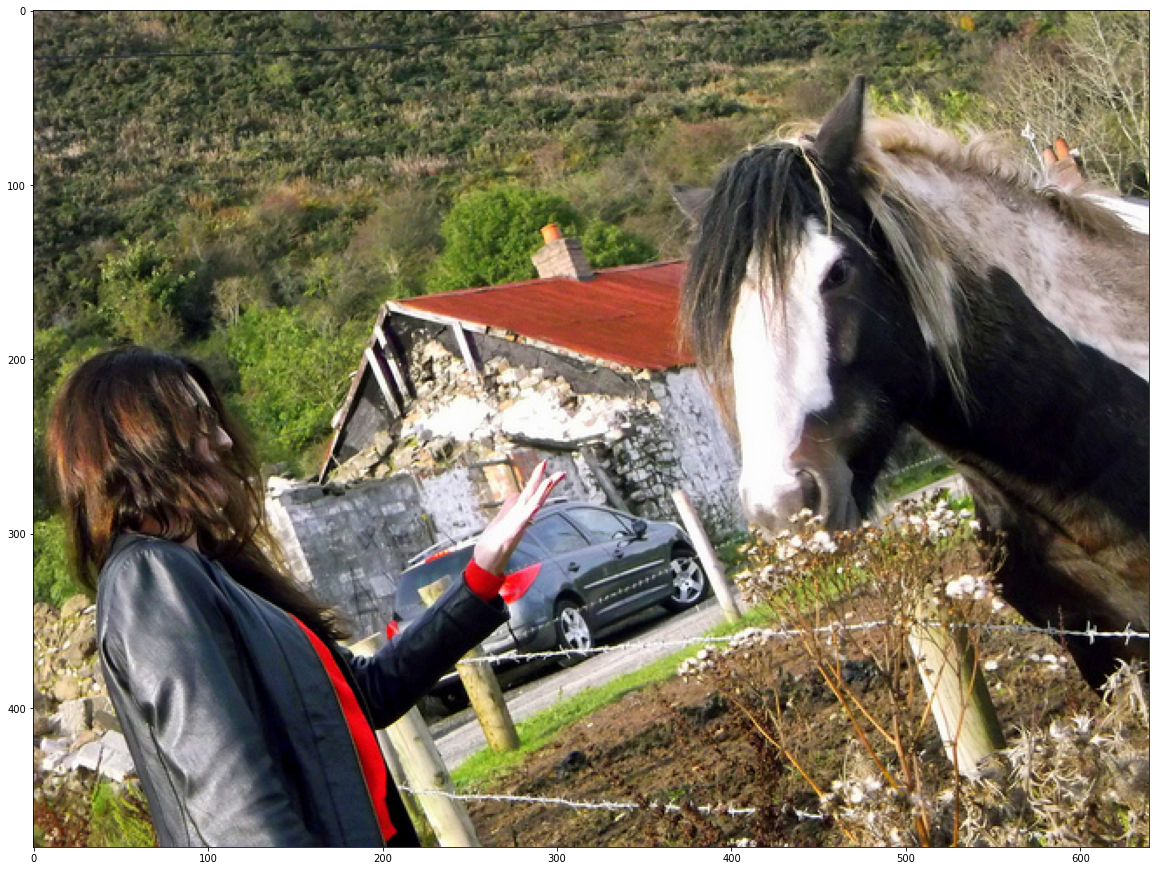

In [56]:
import urllib.request

import matplotlib.pyplot as plt
import torchvision.datasets.folder as tv_helpers

from mmf.common.sample import Sample, SampleList


def create_sample(image, text):
  # Create a Sample
  current_sample = Sample()

  # Preprocess the text to generate tokens
  processed_text = mmf_processors["text_processor"]({"text": text})
  current_sample.update(processed_text)
  
  # Load the image and run image preprocessors on it
  current_sample.image = mmf_processors["image_processor"](image)

  # Create a sample list
  sample_list = SampleList([current_sample])
  sample_list = sample_list.to("cuda")
  return sample_list

image_url = "http://images.cocodataset.org/train2017/000000444444.jpg" #@param {type:"string"}
question = "Which man?" #@param {type:"string"}
urllib.request.urlretrieve(image_url, "/content/local.jpg")
image = tv_helpers.default_loader("/content/local.jpg")
print("Image :: \n")
plt.imshow(image)
print("Question :: ", question)

output = model(create_sample(image, question))
output = torch.nn.functional.softmax(output["scores"], dim=1)
prob, indices = output.topk(1, dim=1)
answer = mmf_processors["answer_processor"].idx2word(indices[0][0])
print(answer)
